# Rede Neural de Múltiplas Camadas para Regressão Simbólica

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LassoLarsCV
import warnings
import os
import pickle

# ignoramos os resultados NaN das funções pois vamnos zera-los
np.seterr(invalid='ignore')
# nao quero warning de convergência
warnings.filterwarnings('ignore')

In [2]:
def getResults(fname='results.pkl'):
    dataset = []
    algoritmo = []
    ninter_l = []
    inter_min_l  = []
    inter_max_l  = []
    msre_l = []
    if os.path.exists(fname):
        fw = open(fname, 'rb')
        dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l  = pickle.load(fw)
        fw.close()
    return dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l

In [3]:
def storeResults(dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l, fname='results.pkl'):
    fw = open(fname, 'wb')
    pickle.dump((dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l), fw)
    fw.close()

- calcula mean square root error

In [4]:
def msre(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

- carrega os dados do arquivo fname e retorna X, y

In [5]:
def importaDados(fname):
    dataset = np.loadtxt(fname, delimiter=",")
    X = dataset[:, :-1]
    y = dataset[:, -1]
    return (X, y)

- gera a rede de expoentes entre inter_min (incl) e inter_max (excl)
- para todo atributo da base que contém algum zero na coluna, o expoente correspondente é alterado para o valor absoluto dele a fim de não fazer 1/0, pois gerava alguns Inf que fazia com que a base toda ficasse 0 por padrão.

In [6]:
def geraRede(X, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = np.random.randint(inter_min, inter_max, size=(n_inputs, n_inter))
    for i in range(0, n_inputs):
        if 0 in X[:,i]:
            rede[i,:] = np.absolute(rede[i,:])
    return rede

- recebe uma matriz X e uma rede de expoentes
- retorna os dados transformados
- substitui todos os valores NaN e Inf para 0

In [7]:
def transformData(X, rede):
    n_rows = X.shape[0]
    n_inter = rede.shape[1]
    layers = np.ndarray((n_rows, 3*n_inter))
    for i in range(0, n_inter*3, 3):
        power = X**rede[:,int(i/3)]
        layers[:,i] = np.prod(power,axis=1) # id
        layers[:,i+1] = np.cos(layers[:,i]) # cos
        layers[:,i+2] = np.sqrt(layers[:,i]) # sqrt
    cols = np.any(np.isnan(layers), axis=0)
    layers[:, cols] = 0
    cols = np.any(np.isinf(layers), axis=0)
    layers[:, cols] = 0
    return layers

- Cria a camada de expoentes da rede com n_inter neurônios
- Aplica a função transformData em X_train utilizando essa rede
- Divida a base entre treino e validação
- Aplique o LassoCV e LassoLarsCV, verifique na validação o que retorna o menor erro
- Retorne a rede e o modelo de menor erro
- expoentes aleatorios de 0 a 2

In [8]:
def fit(X, y, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = geraRede(X, n_inter, inter_min, inter_max)
    X_transf = transformData(X, rede)
    lasso = LassoCV(max_iter=5e4, cv=3)
    lassoLars = LassoLarsCV(max_iter=5e4, cv=3)
    lasso.fit(X_transf, y)
    lassoLars.fit(X_transf, y)
    return rede, lasso, lassoLars

- Aplica transformData em X_test usando a rede
- Aplique o método predict de modelo na base transformada e armazena a saída em y_hat
- Retorna y_hat

In [9]:
def predict(X, rede, modelo):
    X_transf = transformData(X, rede)
    y_hat = modelo.predict(X_transf)
    return y_hat

- main

In [10]:
dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l = getResults('results.pkl')

In [11]:
algoritmos = ['lasso', 'lassoLars']
ninter_list = [10, 50, 100]
inter_min_max = [(-1,1), (-2,2), (-3,3), (-4,4), (-5,5), (0,1), (0,2), (0,3), (0,4), (0,5)]
pastas = ['0', '1', '2', '3', '4']
#bases = ['airfoil', 'concrete', 'cpu', 'energyCooling', 'energyHeating', 'forestfires', 'towerData', 'wineRed', 'wineWhite', 'yacht']
#basesquebugam = ['bioavailability', 'ppb']

In [35]:
#for D in bases:
D = 'bioavailability'
#for ninter in ninter_list:
ninter = 10
for (inter_min, inter_max) in inter_min_max:
    dataset += [D, D]
    ninter_l += [ninter, ninter]
    inter_min_l += [inter_min, inter_min]
    inter_max_l += [inter_max, inter_max]
    algoritmo += ['lasso', 'lassoLars']
    msre_lasso = 0
    msre_lassoLars = 0
    for pasta in pastas:
        fileTrain = 'datasets/' + D + '-train-' + pasta + '.dat'
        X, y = importaDados(fileTrain)
        n = X.shape[1]
        X_treino, X_validacao, y_treino, y_validacao = train_test_split(X, y, test_size=0.3, random_state=1)
        rede, lasso, lassoLars = fit(X_treino, y_treino, ninter*n, inter_min, inter_max+1)
        y_lasso = predict(X_validacao, rede, lasso)
        y_lars = predict(X_validacao, rede, lassoLars)
        msre_lasso += msre(y_validacao, y_lasso)
        msre_lassoLars += msre(y_validacao, y_lars)
    m = len(pastas)
    msre_l += [msre_lasso/m, msre_lassoLars/m]

ValueError: x and y arrays must have at least 2 entries

In [ ]:
storeResults(dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l, 'results.pkl')

In [12]:
dataframe = {'dataset':dataset, 
             'algoritmo':algoritmo, 
             'ninter': ninter_l, 
             'inter_min':inter_min_l, 
             'inter_max':inter_max_l, 
             'msre':msre_l}
df = pd.DataFrame(dataframe)
# salvar o df no arquivo
fw = open('df.pkl', 'wb')
pickle.dump(df, fw)
fw.close()

In [ ]:
# carregar o df do arquivo
fw = open('df.pkl', 'rb')
df = pickle.load(fw)
fw.close()

In [13]:
# datasets que já estão no df
df.dataset.unique()

array(['airfoil', 'concrete', 'cpu', 'energyCooling', 'energyHeating',
       'forestfires', 'wineRed'], dtype=object)

### airfoil



In [44]:
# linha com menor msre
i = df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == 'lassoLars']['msre'].idxmin()
df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == 'lassoLars'].loc[i]

algoritmo    lassoLars
dataset        airfoil
inter_max            2
inter_min           -2
msre           2.89776
ninter              10
Name: 3, dtype: object

In [34]:
df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == 'lassoLars']

,algoritmo,dataset,inter_max,inter_min,msre,ninter
1,lassoLars,airfoil,1,-1,3.715972,10
3,lassoLars,airfoil,2,-2,2.897756,10
5,lassoLars,airfoil,3,-3,3.227055,10
7,lassoLars,airfoil,4,-4,3.489496,10
9,lassoLars,airfoil,5,-5,4.193533,10
11,lassoLars,airfoil,1,0,4.095604,10
13,lassoLars,airfoil,2,0,3.821782,10
15,lassoLars,airfoil,3,0,3.666130,10
17,lassoLars,airfoil,4,0,3.952306,10
19,lassoLars,airfoil,5,0,3.945263,10


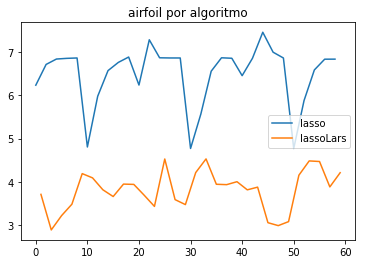

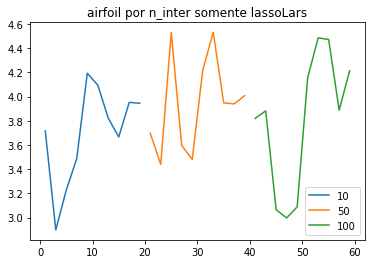

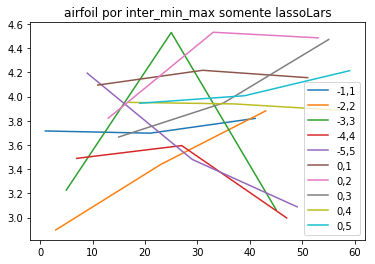

In [33]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='airfoil por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='airfoil por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == 'lassoLars'].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='airfoil por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### concrete



In [45]:
# linha com menor msre
i = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == 'lassoLars']['msre'].idxmin()
df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == 'lassoLars'].loc[i]

algoritmo    lassoLars
dataset       concrete
inter_max            2
inter_min           -2
msre           6.65484
ninter             100
Name: 103, dtype: object

In [33]:
df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == 'lassoLars']

,algoritmo,dataset,inter_max,inter_min,msre,ninter
61,lassoLars,concrete,1,-1,7.223500,10
63,lassoLars,concrete,2,-2,9.623110,10
65,lassoLars,concrete,3,-3,10.566901,10
67,lassoLars,concrete,4,-4,12.030566,10
69,lassoLars,concrete,5,-5,12.171264,10
71,lassoLars,concrete,1,0,8.130073,10
73,lassoLars,concrete,2,0,7.881218,10
75,lassoLars,concrete,3,0,8.971452,10
77,lassoLars,concrete,4,0,12.372455,10
79,lassoLars,concrete,5,0,11.631606,10


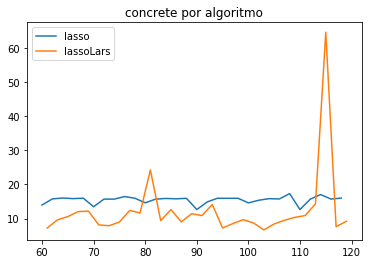

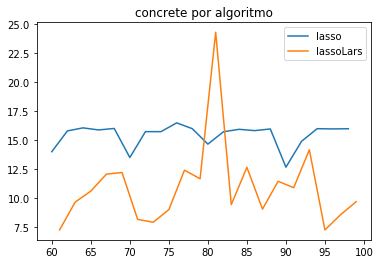

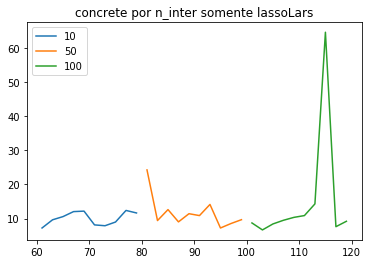

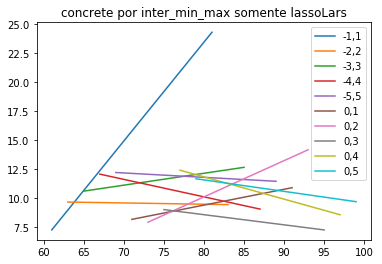

In [41]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='concrete por algoritmo', label=algoritmo, legend=True)
plt.show()
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == algoritmo].loc[df['ninter'] != 100]['msre']
    S.plot(title='concrete por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='concrete por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] != 100].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='concrete por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### cpu



In [48]:
# linha com menor msre
i = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == 'lassoLars']['msre'].idxmin()
df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == 'lassoLars'].loc[i]

algoritmo    lassoLars
dataset            cpu
inter_max            2
inter_min           -2
msre           38.7764
ninter             100
Name: 163, dtype: object

In [32]:
df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == 'lassoLars']

,algoritmo,dataset,inter_max,inter_min,msre,ninter
121,lassoLars,cpu,1,-1,40.378950,10
123,lassoLars,cpu,2,-2,152.334197,10
125,lassoLars,cpu,3,-3,1086.770248,10
127,lassoLars,cpu,4,-4,295.995066,10
129,lassoLars,cpu,5,-5,2136.534605,10
131,lassoLars,cpu,1,0,55.377622,10
133,lassoLars,cpu,2,0,96.720438,10
135,lassoLars,cpu,3,0,446.046273,10
137,lassoLars,cpu,4,0,369.956625,10
139,lassoLars,cpu,5,0,316.901268,10


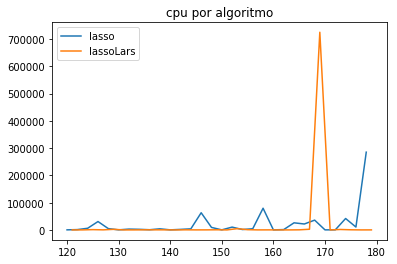

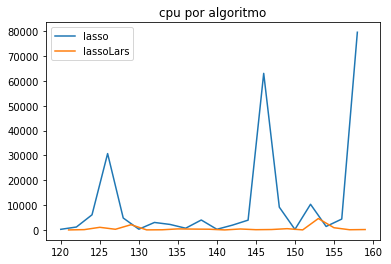

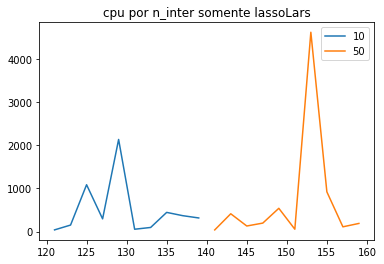

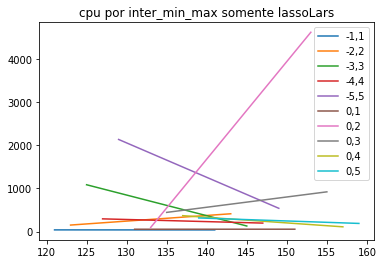

In [35]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='cpu por algoritmo', label=algoritmo, legend=True)
plt.show()
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == algoritmo].loc[df['ninter'] != 100]['msre']
    S.plot(title='cpu por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    if ninter != 100:
        S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
        S.plot(title='cpu por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] != 100].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='cpu por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### energyCooling



In [49]:
# linha com menor msre
i = df.loc[df['dataset'] == 'energyCooling'].loc[df['algoritmo'] == 'lassoLars']['msre'].idxmin()
df.loc[df['dataset'] == 'energyCooling'].loc[df['algoritmo'] == 'lassoLars'].loc[i]

algoritmo        lassoLars
dataset      energyCooling
inter_max                3
inter_min                0
msre               1.86692
ninter                 100
Name: 235, dtype: object

In [31]:
df.loc[df['dataset'] == 'energyCooling'].loc[df['algoritmo'] == 'lassoLars']

,algoritmo,dataset,inter_max,inter_min,msre,ninter
181,lassoLars,energyCooling,1,-1,4.331015,10
183,lassoLars,energyCooling,2,-2,3.581859,10
185,lassoLars,energyCooling,3,-3,3.402435,10
187,lassoLars,energyCooling,4,-4,4.930082,10
189,lassoLars,energyCooling,5,-5,4.019001,10
191,lassoLars,energyCooling,1,0,3.311558,10
193,lassoLars,energyCooling,2,0,2.137583,10
195,lassoLars,energyCooling,3,0,2.876839,10
197,lassoLars,energyCooling,4,0,2.988538,10
199,lassoLars,energyCooling,5,0,3.428266,10


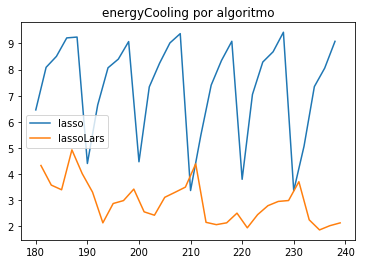

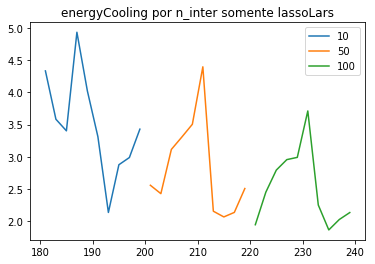

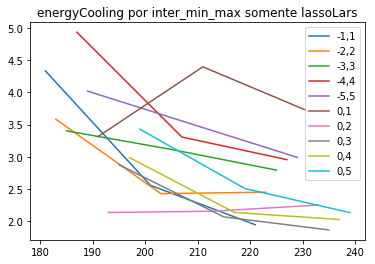

In [14]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'energyCooling'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='energyCooling por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'energyCooling'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='energyCooling por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'energyCooling'].loc[df['algoritmo'] == 'lassoLars'].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='energyCooling por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### energyHeating



In [50]:
# linha com menor msre
i = df.loc[df['dataset'] == 'energyHeating'].loc[df['algoritmo'] == 'lassoLars']['msre'].idxmin()
df.loc[df['dataset'] == 'energyHeating'].loc[df['algoritmo'] == 'lassoLars'].loc[i]

algoritmo        lassoLars
dataset      energyHeating
inter_max                2
inter_min                0
msre              0.533508
ninter                 100
Name: 293, dtype: object

In [30]:
df.loc[df['dataset'] == 'energyHeating'].loc[df['algoritmo'] == 'lassoLars']

,algoritmo,dataset,inter_max,inter_min,msre,ninter
241,lassoLars,energyHeating,1,-1,2.322595,10
243,lassoLars,energyHeating,2,-2,4.341269,10
245,lassoLars,energyHeating,3,-3,6.459015,10
247,lassoLars,energyHeating,4,-4,5.035893,10
249,lassoLars,energyHeating,5,-5,5.657043,10
251,lassoLars,energyHeating,1,0,1.519485,10
253,lassoLars,energyHeating,2,0,0.908628,10
255,lassoLars,energyHeating,3,0,2.175943,10
257,lassoLars,energyHeating,4,0,2.631692,10
259,lassoLars,energyHeating,5,0,3.110257,10


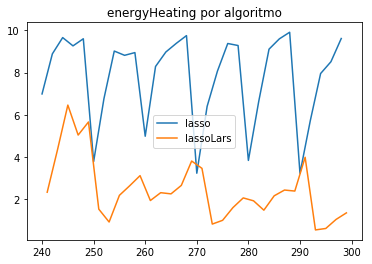

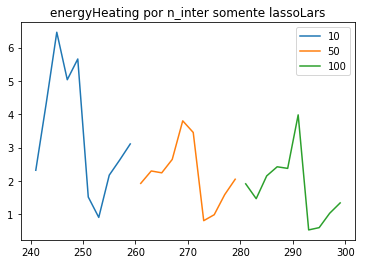

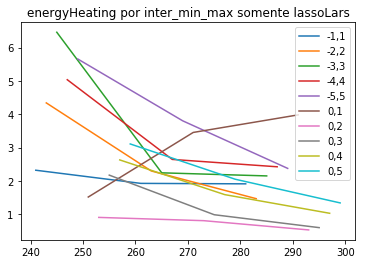

In [15]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'energyHeating'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='energyHeating por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'energyHeating'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='energyHeating por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'energyHeating'].loc[df['algoritmo'] == 'lassoLars'].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='energyHeating por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### forestfires


In [51]:
# linha com menor msre
i = df.loc[df['dataset'] == 'forestfires'].loc[df['algoritmo'] == 'lassoLars']['msre'].idxmin()
df.loc[df['dataset'] == 'forestfires'].loc[df['algoritmo'] == 'lassoLars'].loc[i]

algoritmo      lassoLars
dataset      forestfires
inter_max              1
inter_min             -1
msre             60.6012
ninter                50
Name: 321, dtype: object

In [29]:
df.loc[df['dataset'] == 'forestfires'].loc[df['algoritmo'] == 'lassoLars']

,algoritmo,dataset,inter_max,inter_min,msre,ninter
301,lassoLars,forestfires,1,-1,60.631696,10
303,lassoLars,forestfires,2,-2,60.602118,10
305,lassoLars,forestfires,3,-3,60.602118,10
307,lassoLars,forestfires,4,-4,60.602118,10
309,lassoLars,forestfires,5,-5,60.602118,10
311,lassoLars,forestfires,1,0,60.602118,10
313,lassoLars,forestfires,2,0,60.602118,10
315,lassoLars,forestfires,3,0,60.602118,10
317,lassoLars,forestfires,4,0,60.602118,10
319,lassoLars,forestfires,5,0,60.602118,10


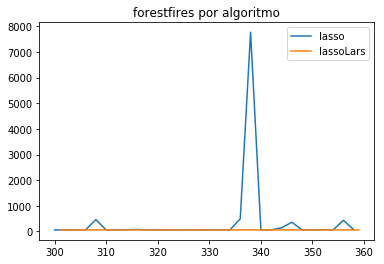

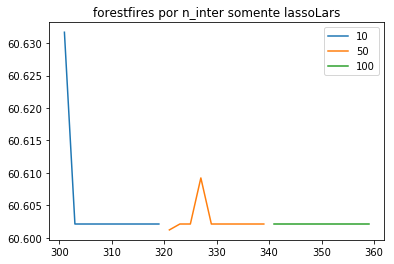

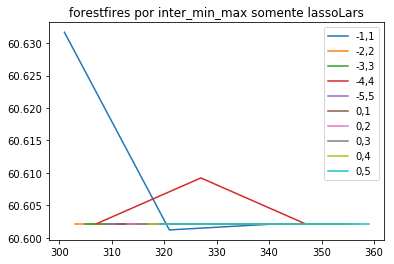

In [16]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'forestfires'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='forestfires por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'forestfires'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='forestfires por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'forestfires'].loc[df['algoritmo'] == 'lassoLars'].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='forestfires por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### wineRed

In [16]:
# linha com menor msre
i = df.loc[df['dataset'] == 'wineRed'].loc[df['algoritmo'] == 'lassoLars']['msre'].idxmin()
df.loc[df['dataset'] == 'wineRed'].loc[df['algoritmo'] == 'lassoLars'].loc[i]

algoritmo    lassoLars
dataset        wineRed
inter_max            1
inter_min           -1
msre          0.645472
ninter             100
Name: 401, dtype: object

In [17]:
df.loc[df['dataset'] == 'wineRed'].loc[df['algoritmo'] == 'lassoLars']

,algoritmo,dataset,inter_max,inter_min,msre,ninter
361,lassoLars,wineRed,1,-1,0.661262,10
363,lassoLars,wineRed,2,-2,0.682851,10
365,lassoLars,wineRed,3,-3,0.697053,10
367,lassoLars,wineRed,4,-4,0.704699,10
369,lassoLars,wineRed,5,-5,0.720664,10
371,lassoLars,wineRed,1,0,0.659446,10
373,lassoLars,wineRed,2,0,0.856080,10
375,lassoLars,wineRed,3,0,0.734708,10
377,lassoLars,wineRed,4,0,0.783967,10
379,lassoLars,wineRed,5,0,0.771236,10


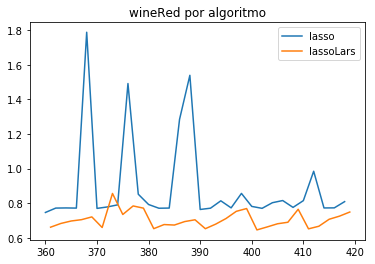

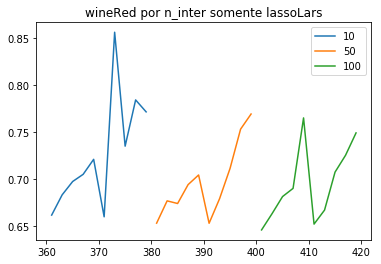

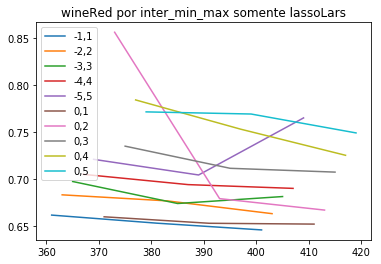

In [18]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'wineRed'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='wineRed por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'wineRed'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='wineRed por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'wineRed'].loc[df['algoritmo'] == 'lassoLars'].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='wineRed por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()